In [1]:
initial_path = 'peptide-QML/'
# initial_path = '../'

In [2]:
day = "0829"
name_notebook = day + "-sh_em_1qm.ipynb"

#ask the user if that is correct, if he says yes kkep going, otherwise stop
import sys
answer = input("{} is the name of the notebook | Is that correct? (y/n): ".format(name_notebook))
if answer != "y":
    print("Please, change the name of the notebook")
    sys.exit()

In [3]:
import numpy as np

In [4]:
import sys
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import functions as f
from my_code import pytorch_model as ptm
from my_code import quantum_nodes as qn
from my_code import pytorch_wrappers as pw

# Data

In [5]:
data_file_path = initial_path + 'data/Scores/PET/generated/bb14_Strings_Energies_10_000_4_aa.txt'  # Replace with the actual path to your 'data.txt' file
string_list, number_list = f.read_data_file(data_file_path)
score_list = np.array(number_list)/1000
vector_list = np.array([f.string_to_numbers(string) for string in string_list]) # one hot encoding

In [6]:
X, Y, X_validation, Y_validation = f.create_validating_set(vector_list, score_list, percentage=0.1)

In [7]:
# Define the dataset
input_data = ptm.torch.tensor(X) 
target_data = ptm.torch.tensor(Y).view(-1, 1)

# Define the validation set
input_validation = ptm.torch.tensor(X_validation)
target_validation = ptm.torch.tensor(Y_validation).view(-1, 1)

In [8]:
input_data.shape, target_data.shape, input_validation.shape, target_validation.shape

(torch.Size([9000, 4]),
 torch.Size([9000, 1]),
 torch.Size([1000, 4]),
 torch.Size([1000, 1]))

# Quantum node

In [9]:
n_aminoacids = len(string_list[0])

In [10]:
quantum_layer = qn.circuit(
    n_qubits = n_aminoacids, 
    device = "default.qubit.torch",
    device_options = {'shots': None},
    embedding = qn.parts.AngleEmbedding, 
    # embedding_ansatz = qn.parts.Ansatz_11,
    block_ansatz = qn.parts.Ansatz_11,
    final_ansatz = qn.parts.Ansatz_final_11,
    measurement = qn.parts.Measurement('Z', (n_aminoacids-1)//2),
    # embedding_n_layers = 4,
    # different_inputs_per_layer = True,
    block_n_layers = 5,
    # wrapper_qlayer = pw.QLayerEmpty,
)

In [11]:
quantum_layer.weights_shape, quantum_layer.input_shape

({'block_weights': (60,), 'final_weights': (12,)}, (4,))

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  

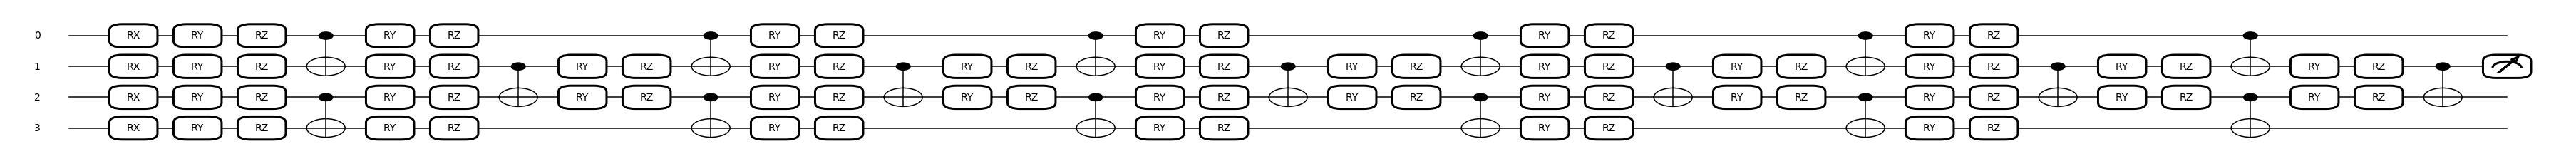

In [12]:
quantum_layer.draw(size=(50,3))

# Hybrid model

In [13]:
input_dim = input_data.size(1)

n_pre_classical_layers = 4
layers_dim = np.linspace(n_aminoacids, input_dim, 4).astype(int)

In [14]:
import torch.nn as nn
import torch
class ClippedReLU(nn.Module):
    def __init__(self, clip_val=1):
        super(ClippedReLU, self).__init__()
        self.clip_val = clip_val

    def forward(self, x):
        return torch.clamp(x, 0, self.clip_val)
    
class Reshape(nn.Module):
    def __init__(self):
        super(Reshape, self).__init__()

    def forward(self, x):
        dims = len(x.shape)
        return torch.transpose(x, dims-2, dims-1).reshape(x.shape[-3] if dims==3 else 1, x.shape[-2]*x.shape[-1]).squeeze()

In [15]:
layers =  [ptm.nn.Embedding(num_embeddings=19, embedding_dim=quantum_layer.input_shape[0]//n_aminoacids), Reshape()]
layers += [quantum_layer(), ptm.nn.Linear(1,1)]


In [16]:
# layers = []
# for i in range(1, len(layers_dim)):
#     layers += [ptm.nn.Linear(layers_dim[-1*i], layers_dim[-1*(i+1)]), ptm.nn.ReLU()]
# layers += [ptm.nn.Linear(layers_dim[0], layers_dim[0]), ClippedReLU()]
# layers += [quantum_layer()]
# # layers += [nn.Linear(1, 1)]
# # layers += [nn.Linear(2, 4), nn.ReLU()]
# # layers += [nn.Linear(4, 1)]

In [17]:
# Create model and set data:
model = ptm.pytorch_model(
    layers,    
    save_options = {'initial_path': initial_path, 'name_notebook': name_notebook},
)
model.set_data(
    data_X=input_data, 
    data_Y=target_data, 
    data_X_validation=input_validation,
    data_Y_validation=target_validation
)

In [18]:
x = input_data[0:2]
for i, layer in enumerate(model.model):
    x = layer(x)
    print(i, x.shape, x)

0 torch.Size([2, 4, 1]) tensor([[[ 0.0016],
         [-0.3576],
         [ 1.3373],
         [ 1.3001]],

        [[-0.0271],
         [ 0.9899],
         [ 0.1914],
         [ 1.3373]]], grad_fn=<EmbeddingBackward>)
1 torch.Size([2, 4]) tensor([[ 0.0016, -0.3576,  1.3373,  1.3001],
        [-0.0271,  0.9899,  0.1914,  1.3373]], grad_fn=<SqueezeBackward0>)
2 torch.Size([2, 1]) tensor([[ 0.1617],
        [-0.1186]], grad_fn=<ViewBackward>)
3 torch.Size([2, 1]) tensor([[-0.8974],
        [-1.0214]], grad_fn=<AddmmBackward>)


In [19]:
for i in range(2):
    x = input_data[i]
    for i, layer in enumerate(model.model):
        x = layer(x)
        print(i, x.shape, x)

    print('')

0 torch.Size([4, 1]) tensor([[ 0.0016],
        [-0.3576],
        [ 1.3373],
        [ 1.3001]], grad_fn=<EmbeddingBackward>)
1 torch.Size([4]) tensor([ 0.0016, -0.3576,  1.3373,  1.3001], grad_fn=<SqueezeBackward0>)
2 torch.Size([1]) tensor([0.1617], grad_fn=<CatBackward>)
3 torch.Size([1]) tensor([-0.8974], grad_fn=<AddBackward0>)

0 torch.Size([4, 1]) tensor([[-0.0271],
        [ 0.9899],
        [ 0.1914],
        [ 1.3373]], grad_fn=<EmbeddingBackward>)
1 torch.Size([4]) tensor([-0.0271,  0.9899,  0.1914,  1.3373], grad_fn=<SqueezeBackward0>)
2 torch.Size([1]) tensor([-0.1186], grad_fn=<CatBackward>)
3 torch.Size([1]) tensor([-1.0214], grad_fn=<AddBackward0>)



In [20]:
print(model(input_data[0:2]))
print(model(input_data[1]))

tensor([[-0.8974],
        [-1.0214]], grad_fn=<AddmmBackward>)
tensor([-1.0214], grad_fn=<AddBackward0>)


In [21]:
model.keep_track_params=False

In [22]:
import torch.optim as optim

# ask the user if he wants to start the training
out = input("Do you want to start the training? (y/n) ")
if out != 'y':
    sys.exit()

# train the model
model.train(
    optimizer= optim.Adam,
    optimizer_options={'lr': 0.1},
    num_epochs = 50,                
    batch_size = 32,
)

Epoch [0/50], Loss: 7.5802, Loss validation: 6.7074


/usr/lib/python3/dist-packages/torch/autograd/__init__.py:147: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:115.)
  Variable._execution_engine.run_backward(


	 Validation string, 	 i: 0; 	 prediction: 0.3071, 	 target: 0.1776, 	 loss: 0.7293
	 Validation string, 	 i: 1; 	 prediction: 0.3690, 	 target: -0.0325, 	 loss: 12.3381
	 Validation string, 	 i: 2; 	 prediction: 0.3245, 	 target: -0.0805, 	 loss: 5.0328
Epoch [1/50], Loss: 3.0623, Loss validation: 2.0403, Time remaining: ~0.0h 11.0m 16s
	 Validation string, 	 i: 0; 	 prediction: 0.7546, 	 target: 0.1776, 	 loss: 3.2488
	 Validation string, 	 i: 1; 	 prediction: 0.7694, 	 target: -0.0325, 	 loss: 24.6378
	 Validation string, 	 i: 2; 	 prediction: 0.7416, 	 target: -0.0805, 	 loss: 10.2154
Epoch [2/50], Loss: 3.1331, Loss validation: 4.8118, Time remaining: ~0.0h 10.0m 19s
	 Validation string, 	 i: 0; 	 prediction: 0.6434, 	 target: 0.1776, 	 loss: 2.6225
	 Validation string, 	 i: 1; 	 prediction: 0.6232, 	 target: -0.0325, 	 loss: 20.1458
	 Validation string, 	 i: 2; 	 prediction: 0.5976, 	 target: -0.0805, 	 loss: 8.4259
Epoch [3/50], Loss: 3.0896, Loss validation: 3.9768, Time remain

In [23]:
# save string of the model
model.save_str(
    metadata={
        "data_file_path": data_file_path,
        "Quantum_circuit": quantum_layer.__str__(),
    }
)

Saved in:  peptide-QML/checkpoints/0829/txts/0829-sh_em_1qm_model_str_8.txt


In [33]:
len(model.parameters)

14101

The file peptide-QML/checkpoints/0829/plots/0829-sh_em_1qm_losses_batches_8.png already exists, it will be replaced
Saved in:  peptide-QML/checkpoints/0829/plots/0829-sh_em_1qm_losses_batches_8.png


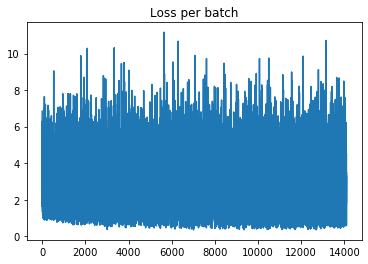

Saved in:  peptide-QML/checkpoints/0829/plots/0829-sh_em_1qm_losses_epochs_8.png


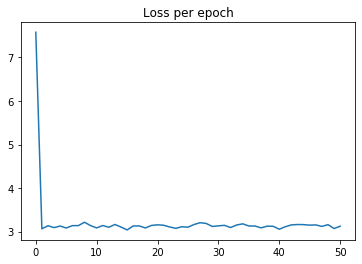

Saved in:  peptide-QML/checkpoints/0829/plots/0829-sh_em_1qm_losses_epochs_validation_8.png


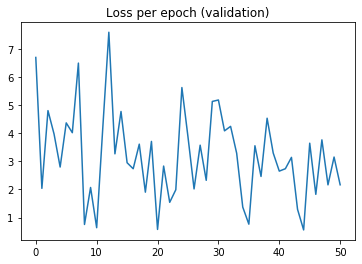

The file peptide-QML/checkpoints/0829/txts/0829-sh_em_1qm_losses_batches_8.txt already exists, it will be replaced
Saved in:  <_io.TextIOWrapper name='peptide-QML/checkpoints/0829/txts/0829-sh_em_1qm_losses_batches_8.txt' mode='w' encoding='UTF-8'>
Saved in:  <_io.TextIOWrapper name='peptide-QML/checkpoints/0829/txts/0829-sh_em_1qm_losses_epochs_8.txt' mode='w' encoding='UTF-8'>
Saved in:  <_io.TextIOWrapper name='peptide-QML/checkpoints/0829/txts/0829-sh_em_1qm_losses_epochs_validation_8.txt' mode='w' encoding='UTF-8'>


In [37]:
# plot the losses of the trainig loop and save the figures
model.plot_losses(save=True, save_txt=True)

The file peptide-QML/checkpoints/0829/plots/0829-sh_em_1qm_parameter_0.weight_None_8.png already exists, it will be replaced
Saved in:  peptide-QML/checkpoints/0829/plots/0829-sh_em_1qm_parameter_0.weight_None_8.png


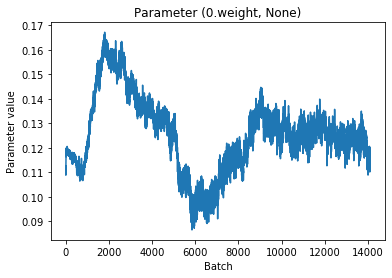

The file peptide-QML/checkpoints/0829/plots/0829-sh_em_1qm_parameter_2.block_weights_None_8.png already exists, it will be replaced
Saved in:  peptide-QML/checkpoints/0829/plots/0829-sh_em_1qm_parameter_2.block_weights_None_8.png


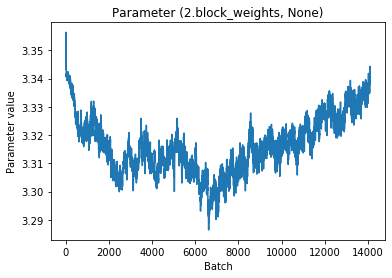

The file peptide-QML/checkpoints/0829/plots/0829-sh_em_1qm_parameter_2.final_weights_None_8.png already exists, it will be replaced
Saved in:  peptide-QML/checkpoints/0829/plots/0829-sh_em_1qm_parameter_2.final_weights_None_8.png


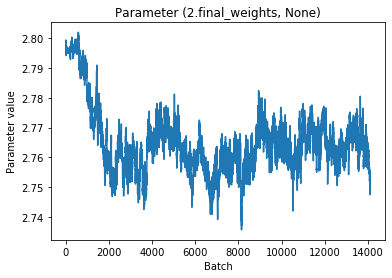

The file peptide-QML/checkpoints/0829/plots/0829-sh_em_1qm_parameter_3.weight_None_8.png already exists, it will be replaced
Saved in:  peptide-QML/checkpoints/0829/plots/0829-sh_em_1qm_parameter_3.weight_None_8.png


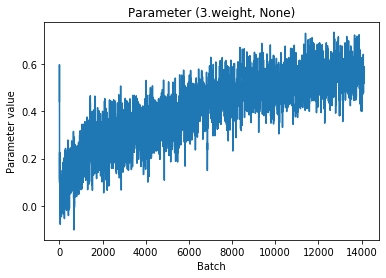

The file peptide-QML/checkpoints/0829/plots/0829-sh_em_1qm_parameter_3.bias_None_8.png already exists, it will be replaced
Saved in:  peptide-QML/checkpoints/0829/plots/0829-sh_em_1qm_parameter_3.bias_None_8.png


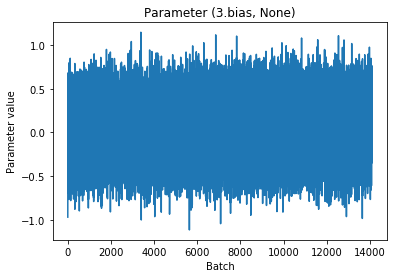

In [31]:
# plot how the average of the parameters in each layer changes over time, and save that
for layer in model.model.state_dict().keys():
    model.plot_parameter(layer=layer, save=True)

In [26]:
# model.plot_parameter(layer='7.weights', index=50)

In [27]:
#save all the parameters of the model and the intermediate parameters of the model
model.save_state_dict(intermediate=False)

Model saved as peptide-QML/checkpoints/0829/models/0829-sh_em_1qm_8.pth


Saved in:  peptide-QML/checkpoints/0829/plots/0829-sh_em_1qm_validation_8.png


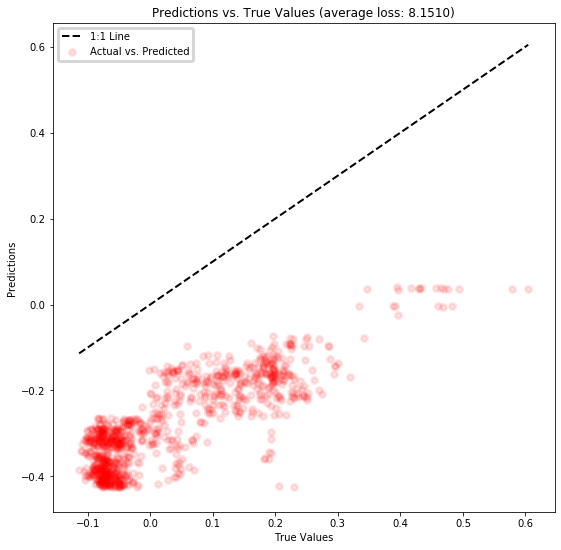

In [28]:
model.plot_validation(save=True, fig_size=(9,9))

In [29]:
# print validation and save it
model.print_validation(save=True, precision=4, percentatge=1)

i: 0, 		 target: 0.1776, 	 prediction: -0.1261, 	 loss: 1.7102
i: 1, 		 target: 0.1533, 	 prediction: -0.2231, 	 loss: 2.4553
i: 2, 		 target: -0.0321, 	 prediction: -0.3209, 	 loss: 8.9886
i: 3, 		 target: -0.0726, 	 prediction: -0.4092, 	 loss: 4.6359
i: 4, 		 target: 0.0729, 	 prediction: -0.1360, 	 loss: 2.8651
i: 5, 		 target: 0.0306, 	 prediction: -0.3359, 	 loss: 11.9715
i: 6, 		 target: -0.0602, 	 prediction: -0.2785, 	 loss: 3.6290
i: 7, 		 target: 0.1206, 	 prediction: -0.2123, 	 loss: 2.7612
i: 8, 		 target: 0.1396, 	 prediction: -0.1961, 	 loss: 2.4048
i: 9, 		 target: -0.0564, 	 prediction: -0.2950, 	 loss: 4.2296
i: 10, 		 target: -0.0325, 	 prediction: -0.3254, 	 loss: 8.9963
i: 11, 		 target: -0.0984, 	 prediction: -0.3109, 	 loss: 2.1585
i: 12, 		 target: 0.1997, 	 prediction: -0.2039, 	 loss: 2.0211
i: 13, 		 target: -0.0149, 	 prediction: -0.3516, 	 loss: 22.5864
i: 14, 		 target: 0.2621, 	 prediction: -0.1767, 	 loss: 1.6742
i: 15, 		 target: 0.1432, 	 prediction: -

In [30]:
# push changes to git
if initial_path != '../':
    !cd peptide-QML && git add . && git commit -m "data trained model" && git push

[main 8fd56a1c] data trained model
 13 files changed, 1041 insertions(+), 1 deletion(-)
 create mode 100644 checkpoints/0829/models/0829-sh_em_1qm_8.pth
 create mode 100644 checkpoints/0829/plots/0829-sh_em_1qm_losses_batches_8.png
 create mode 100644 checkpoints/0829/plots/0829-sh_em_1qm_losses_epoch_8.png
 create mode 100644 checkpoints/0829/plots/0829-sh_em_1qm_losses_epoch_validation_8.png
 create mode 100644 checkpoints/0829/plots/0829-sh_em_1qm_parameter_0.weight_None_8.png
 create mode 100644 checkpoints/0829/plots/0829-sh_em_1qm_parameter_2.block_weights_None_8.png
 create mode 100644 checkpoints/0829/plots/0829-sh_em_1qm_parameter_2.final_weights_None_8.png
 create mode 100644 checkpoints/0829/plots/0829-sh_em_1qm_parameter_3.bias_None_8.png
 create mode 100644 checkpoints/0829/plots/0829-sh_em_1qm_parameter_3.weight_None_8.png
 create mode 100644 checkpoints/0829/plots/0829-sh_em_1qm_validation_8.png
 create mode 100644 checkpoints/0829/txts/0829-sh_em_1qm_model_str_8.txt
 cr